In [5]:
from rdkit import Chem
from rdkit.Chem import AllChem
import hypernetx as hnx
import matplotlib.pyplot as plt

In [19]:
smile="Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1"
smile2="NS(=O)(=O)c1ccc(s1)S(=O)(=O)NCc1cccs1"
smile3="COc1ccc(cc1)N1CC(O)c2cc(sc2S1(=O)=O)S(N)(=O)=O"
smiles = [smile, smile2, smile3]

In [47]:
import requests
from requests import Session
from functools import lru_cache
from typing import Optional, List

BASE_URL = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug'
_session = Session()

@lru_cache(maxsize=128)
def get_trade_name_from_smiles(
    smiles: str,
    timeout: float = 5.0
) -> Optional[str]:
    """
    Sucht per SMILES zuerst die PubChem-CID, dann alle Synonyme und
    wählt daraus einen wahrscheinlichen Handelsnamen (erstes Eintrag ohne
    Ziffern/Bindestriche, beginnend mit Großbuchstaben).
    Gibt None zurück, wenn nichts gefunden oder bei Fehlern.
    """
    try:
        # 1) CID per SMILES holen
        r1 = _session.get(
            f'{BASE_URL}/compound/smiles/{smiles}/cids/JSON',
            timeout=timeout
        )
        r1.raise_for_status()
        cids = r1.json().get('IdentifierList', {}).get('CID', [])
        if not cids:
            return None
        cid = cids[0]

        # 2) Synonyme für diesen CID holen
        r2 = _session.get(
            f'{BASE_URL}/compound/cid/{cid}/synonyms/JSON',
            timeout=timeout
        )
        r2.raise_for_status()
        info = r2.json().get('InformationList', {}).get('Information', [])
        #print(info)
        if not info:
            return None
        synonyms: List[str] = info[0].get('Synonym', [])
        return synonyms[0]

    except requests.RequestException as e:
        # In Produktiv-Code lieber logging statt print()
        print(f"Fehler bei PubChem-Abfrage: {e}")
        return None

In [8]:
mol = Chem.MolFromSmiles(smile)
mol2 = Chem.MolFromSmiles(smile2)
mol3 = Chem.MolFromSmiles(smile3)

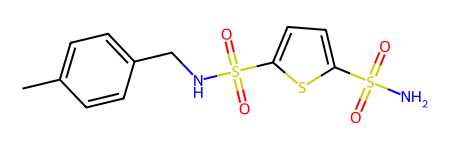

In [9]:
mol

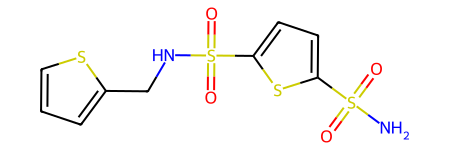

In [10]:
mol2

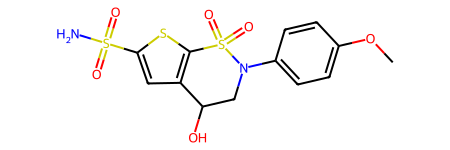

In [11]:
mol3

In [62]:
def create_minimal_hypergraph_with_labels(mol, plot=True):
    """
    Minimaler Hypergraph mit Beschriftungen:
      - Gesamt-Drug-Hyperedge (Trade Name)
      - Ringe (ring_0, ring_1, …)
      - Alle Heteroatome (hetero)
      - Positive/negative Regionen (pos_charge, neg_charge)
      - Rest-Gerüst (rest)
    Node-Labels: AtomSymbol+Index, Edge-Labels: Hyperedge-Namen
    """
    nums_atom = mol.GetNumAtoms()
    hyperedges = {}

    # 0) Gesamtes Molekül als Hyperedge mit Trade Name
    smiles = Chem.MolToSmiles(mol)
    trade_name = get_trade_name_from_smiles(smiles)
    hyperedges[trade_name] = set(range(nums_atom))

    # 1) Ringe
    for i, ring in enumerate(mol.GetRingInfo().AtomRings()):
        hyperedges[f"ring_{i}"] = set(ring)

    # 2) Alle Heteroatome
    hetero = {atom.GetIdx() for atom in mol.GetAtoms() if atom.GetSymbol() in ('S', 'N', 'O')}
    if len(hetero) > 1:
        hyperedges["hetero"] = hetero

    # 3) Partial Charges
    AllChem.ComputeGasteigerCharges(mol)
    pos = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) > 0}
    neg = {i for i in range(nums_atom)
           if float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) < 0}
    if len(pos) > 1:
        hyperedges["pos_charge"] = pos
    if len(neg) > 1:
        hyperedges["neg_charge"] = neg

    # 4) Rest-Gerüst
    covered = set().union(*hyperedges.values()) if hyperedges else set()
    rest = set(range(nums_atom)) - covered
    if len(rest) > 1:
        hyperedges["rest"] = rest

    # Node-Labels: AtomSymbol
    node_labels = {i: f"{mol.GetAtomWithIdx(i).GetSymbol()}" for i in range(nums_atom)}

    if plot:
        H = hnx.Hypergraph(hyperedges)
        plt.figure(figsize=(10, 6))
        hnx.draw(
            H,
            with_node_labels=True,
            node_labels=node_labels,
            with_edge_labels=True
        )
        plt.title(f'Hypergraph of {trade_name}')
        plt.show()

    return hyperedges, node_labels

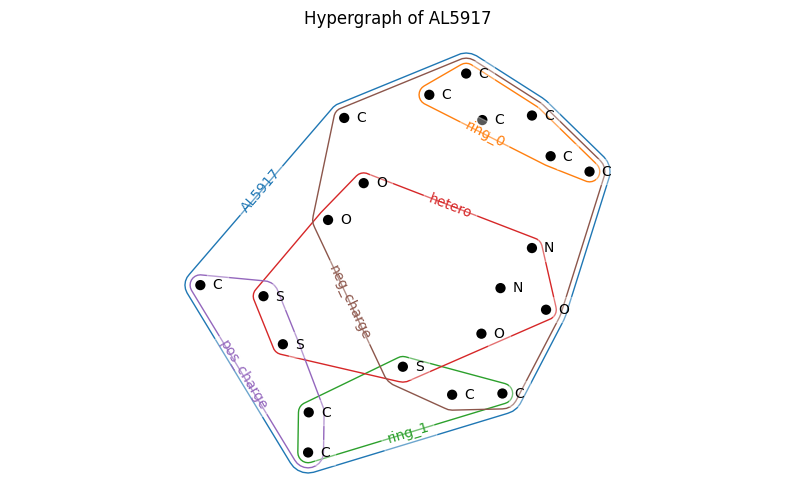

({'AL5917': {0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20},
  'ring_0': {1, 2, 3, 4, 19, 20},
  'ring_1': {10, 11, 12, 13, 14},
  'hetero': {6, 7, 8, 9, 14, 15, 16, 17, 18},
  'pos_charge': {5, 7, 10, 13, 15},
  'neg_charge': {0, 1, 2, 3, 4, 6, 8, 9, 11, 12, 14, 16, 17, 18, 19, 20}},
 {0: 'C',
  1: 'C',
  2: 'C',
  3: 'C',
  4: 'C',
  5: 'C',
  6: 'N',
  7: 'S',
  8: 'O',
  9: 'O',
  10: 'C',
  11: 'C',
  12: 'C',
  13: 'C',
  14: 'S',
  15: 'S',
  16: 'N',
  17: 'O',
  18: 'O',
  19: 'C',
  20: 'C'})

In [63]:
create_minimal_hypergraph_with_labels(mol)

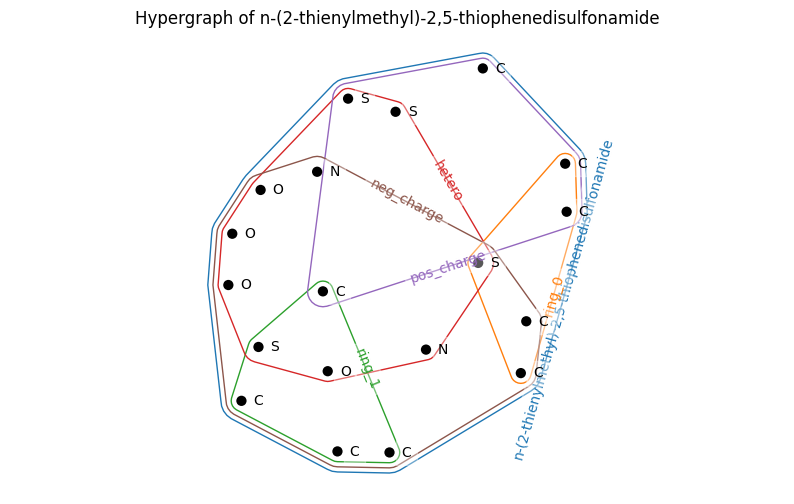

({'n-(2-thienylmethyl)-2,5-thiophenedisulfonamide': {0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18},
  'ring_0': {4, 5, 6, 7, 8},
  'ring_1': {14, 15, 16, 17, 18},
  'hetero': {0, 1, 2, 3, 8, 9, 10, 11, 12, 18},
  'pos_charge': {1, 4, 7, 9, 13, 14},
  'neg_charge': {0, 2, 3, 5, 6, 8, 10, 11, 12, 15, 16, 17, 18}},
 {0: 'N',
  1: 'S',
  2: 'O',
  3: 'O',
  4: 'C',
  5: 'C',
  6: 'C',
  7: 'C',
  8: 'S',
  9: 'S',
  10: 'O',
  11: 'O',
  12: 'N',
  13: 'C',
  14: 'C',
  15: 'C',
  16: 'C',
  17: 'C',
  18: 'S'})

In [64]:
create_minimal_hypergraph_with_labels(mol2)


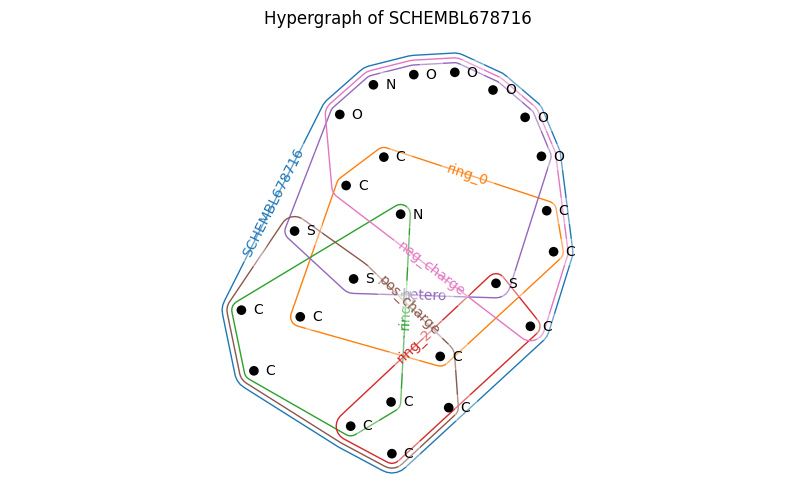

({'SCHEMBL678716': {0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23},
  'ring_0': {2, 3, 4, 5, 6, 7},
  'ring_1': {8, 9, 10, 12, 16, 17},
  'ring_2': {12, 13, 14, 15, 16},
  'hetero': {1, 8, 11, 15, 17, 18, 19, 20, 21, 22, 23},
  'pos_charge': {0, 2, 5, 9, 10, 12, 14, 16, 17, 20},
  'neg_charge': {1, 3, 4, 6, 7, 8, 11, 13, 15, 18, 19, 21, 22, 23}},
 {0: 'C',
  1: 'O',
  2: 'C',
  3: 'C',
  4: 'C',
  5: 'C',
  6: 'C',
  7: 'C',
  8: 'N',
  9: 'C',
  10: 'C',
  11: 'O',
  12: 'C',
  13: 'C',
  14: 'C',
  15: 'S',
  16: 'C',
  17: 'S',
  18: 'O',
  19: 'O',
  20: 'S',
  21: 'N',
  22: 'O',
  23: 'O'})

In [65]:
create_minimal_hypergraph_with_labels(mol3)


In [70]:

def create_shared_hypergraph_with_labels(smiles_list, plot=True):
    """
    Baut einen gemeinsamen Hypergraph mit globalen Indizes und aggregierten Hyperedges:
      - Ringe gruppiert nach Ringgröße (ring_size_N)
      - Heteroatome (hetero)
      - Positive/negative Regionen (pos_charge, neg_charge)
      - Rest-Gerüst (rest)
    Jeder Atomknoten erhält einen eindeutigen globalen Index.
    """
    all_node_labels = {}
    shared_edges = {}
    global_index_offset = 0

    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        local_edges, local_labels = create_minimal_hypergraph_with_labels(mol)
        num_atoms = mol.GetNumAtoms()

        # Remapping lokale Indizes zu globalen Indizes
        remap = {i: global_index_offset + i for i in range(num_atoms)}

        # Node-Labels übernehmen
        for local_idx, label in local_labels.items():
            all_node_labels[remap[local_idx]] = label

        # Hyperedges zusammenführen und Ringe nach Größe benennen
        for label, nodes in local_edges.items():
            if label.startswith('ring_'):
                size = len(nodes)
                shared_label = f'ring_size_{size}'
            else:
                shared_label = label
            mapped_nodes = {remap[i] for i in nodes}
            shared_edges.setdefault(shared_label, set()).update(mapped_nodes)

        global_index_offset += num_atoms

    # Hypergraph erstellen
    H_shared = hnx.Hypergraph(shared_edges)

    if plot:
        plt.figure(figsize=(12, 8))
        hnx.draw(
            H_shared,
            with_node_labels=True,
            node_labels=all_node_labels,
            with_edge_labels=True
        )
        plt.title("Shared Minimal Hypergraph with aggregated Hyperedges")
        plt.show()

    return H_shared, all_node_labels, shared_edges


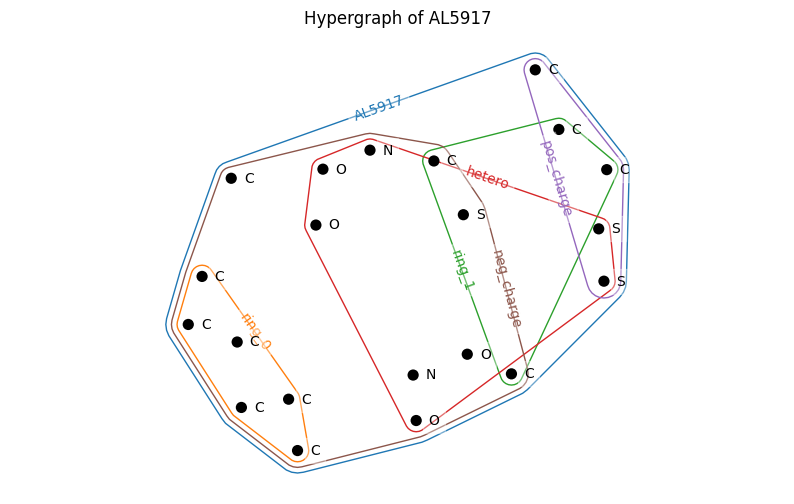

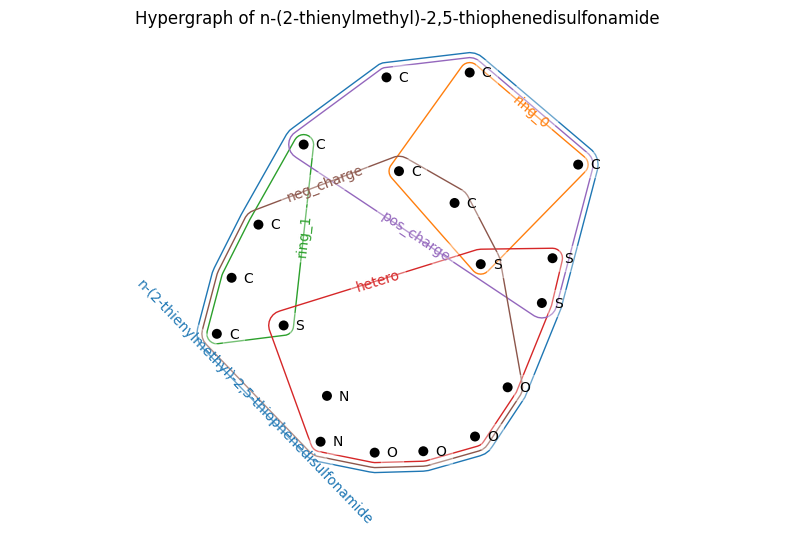

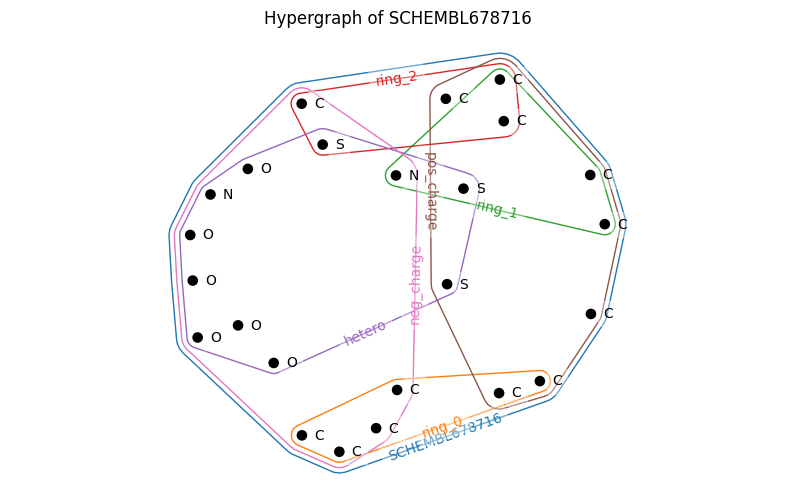

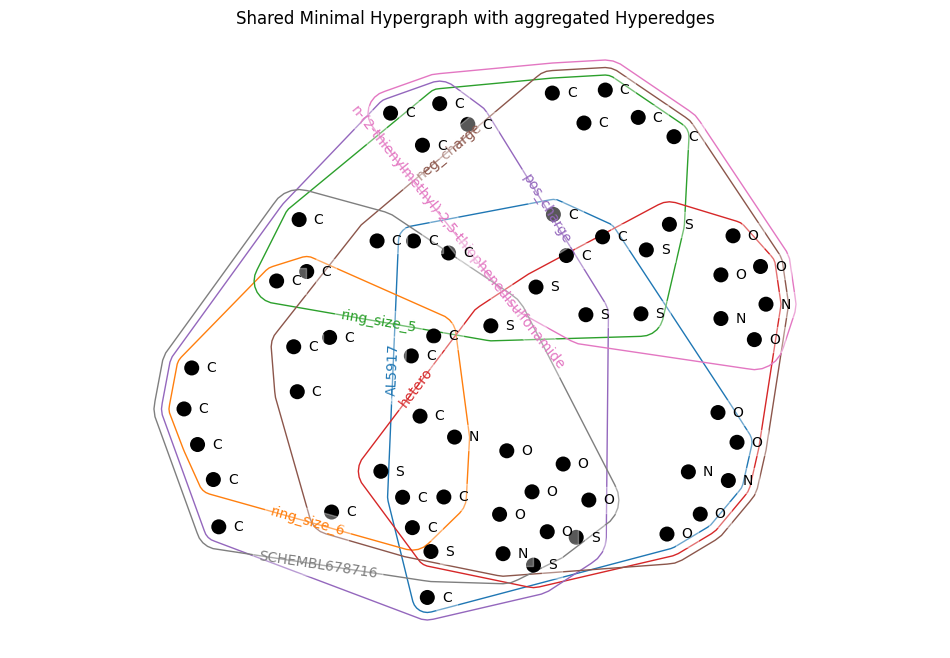

In [71]:
H_shared = create_shared_hypergraph_with_labels(smiles)

In [35]:
def collapse_large_hyperedges(shared_edges, max_size=4):
    """
    Collapses any hyperedge with more than max_size nodes into a single supernode.
    Dadurch erhältst Du einen vereinfachten Knotenraum.

    Parameters
    ----------
    shared_edges : dict
        Mapping von edge_label → set of node-IDs (z.B. (drug_idx, atom_idx)).
    max_size : int
        Ab wie vielen Knoten pro Hyperkante wir zusammenfassen wollen.

    Returns
    -------
    simplified_edges : dict
        Neues Mapping edge_label → set of node-IDs / supernodes.
    node_mapping : dict
        Mapping original_node → new_node (Supernode oder sich selbst).
    """
    simplified_edges = {}
    node_mapping     = {}

    for edge, nodes in shared_edges.items():
        if len(nodes) > max_size:
            # Wir packen ALLE Knoten dieser Kante in genau einen Super-Node
            supernode = f"{edge}_group"
            simplified_edges[edge] = {supernode}
            for n in nodes:
                node_mapping[n] = supernode
        else:
            # Kleine Kanten bleiben erhalten, wir mappen jeden Knoten auf sich selbst
            simplified_edges[edge] = set(nodes)
            for n in nodes:
                node_mapping.setdefault(n, n)

    # Hinweis: Manche Knoten tauchen in mehreren Kanten auf.
    # node_mapping sagt, ob sie einzeln bleiben oder in einen supernode wandern.
    return simplified_edges, node_mapping


def draw_simplified_hypergraph(shared_edges, node_labels, max_size=4):
    """
    Baut aus shared_edges einen zusammengefassten Hypergraphen
    und plottet ihn mit HyperNetX.
    """
    simp_edges, node_map = collapse_large_hyperedges(shared_edges, max_size=max_size)

    # Erzeuge neue Labels für Supernodes
    simp_labels = {}
    for orig, mapped in node_map.items():
        if mapped == orig:
            simp_labels[mapped] = node_labels[mapped]
        else:
            # Auf den ersten Encounter setzen wir ein Label für den Supernode
            if mapped not in simp_labels:
                simp_labels[mapped] = f"{mapped}"
    # Zeichnen
    Hs = hnx.Hypergraph(simp_edges)
    plt.figure(figsize=(10, 6))
    hnx.draw(
        Hs,
        with_node_labels=True,
        node_labels=simp_labels,
        with_edge_labels=True
    )
    plt.title(f"Simplified Hypergraph (max_size={max_size})")
    plt.show()

    return Hs

KeyError: 'ring_0_group'

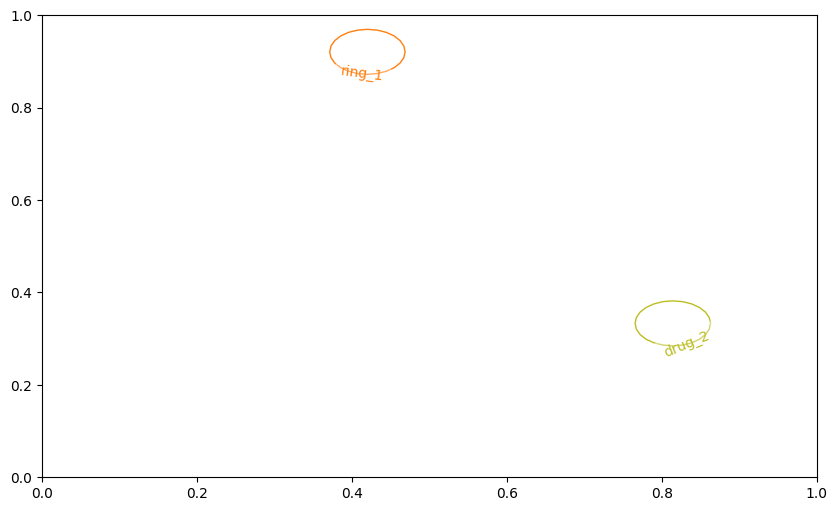

In [37]:
draw_simplified_hypergraph(shared_edges, node_labels)